##### Plot posterior pdf, lik function and prior for a given hyperparameter value

In [1]:
#!/usr/bin/python
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys
np.random.seed(88)
#os.system('rm *.pdf *.eps *.png');

In [2]:
K = 2
Nphi = 2
acoeff  = np.ones((1,K))
mu  = np.zeros((Nphi,K))
Sig = np.zeros((Nphi,Nphi,K))
mu[0,0] = 1.0
mu[1,1] = 1.0
rho = -0.75
var = 0.02
fac = 0.5
Sig[:,:,0] = [[var,var*rho],[var*rho,var]]
Sig[:,:,1] = [[fac*var,fac*var*rho],[fac*var*rho,fac*var]]
r = 1e-04
s = 1e-04

In [3]:
Bmat = np.zeros((Nphi,Nphi,K))
Pmat = np.zeros((Nphi,Nphi,K))
mVec = np.zeros((Nphi,K))
Wraw = np.zeros((1,K))
Vmat = np.zeros((Nphi,K))
jVec = np.zeros((Nphi,1))
Hmat = np.zeros((Nphi,Nphi))

In [4]:
def poststat(X,logalp):
    alp = np.exp(logalp)
    A = np.diag(alp)
    Ain = np.diag(1/alp)
    for i in range(0,K):
        Bmat[:,:,i] = Sig[:,:,i] + Ain
        Wraw[0,i] = acoeff[0,i]*st.multivariate_normal.pdf(mu[:,i],[0]*Nphi,Bmat[:,:,i])
        Pmat[:,:,i] = Ain - Ain@la.inv(Bmat[:,:,i])@Ain
        mVec[:,i] = Pmat[:,:,i]@la.inv(Sig[:,:,i])@mu[:,i]
        for j in range(0,Nphi):
            Vmat[j,i] = (1 - alp[j]*Pmat[j,j,i] + alp[j]*(mVec[j,i]**2))/(2.0*alp[j])
    LogEvid= np.log(np.sum(Wraw))
    ObjFun = LogEvid + np.sum(r*logalp-s*alp)
    Wwght = Wraw/np.sum(Wraw)
    for i in range(0,Nphi):
        jVec[i,0] = alp[i]*np.dot(Wwght,Vmat[i,:]) + r - s*alp[i]
    PostPdf = 0.0
    LikFun = 0.0
    for i in range(0,K):
        LikFun  = LikFun  + acoeff[0,i]*st.multivariate_normal.pdf(X,mu[:,i],Sig[:,:,i])
        PostPdf = PostPdf + Wwght[0,i]*st.multivariate_normal.pdf(X,mVec[:,i],Pmat[:,:,i])  
    PriorPdf = st.multivariate_normal.pdf(X,[0]*Nphi,Ain)
    

    return PriorPdf, LikFun, PostPdf, LogEvid, ObjFun, jVec

In [5]:
Ngrd  = 75
LogEvidgrd  = np.zeros((Ngrd,Ngrd))
ObjFungrd   = np.zeros((Ngrd,Ngrd))
JacVecgrd   = np.zeros((Ngrd,Ngrd,2))
LogAlp1bnd = [-5,10]
LogAlp2bnd = [-5,10]
LogAlp1rng = np.linspacep(φ|D) = N (φ|[1, 0], Σ
(1)) + N (φ|[0, 1], Σ
(2)) ((LogAlp1bnd[0],LogAlp1bnd[1],Ngrd)
LogAlp2rng  = np.linspace(LogAlp2bnd[0],LogAlp2bnd[1],Ngrd)
LogAlp1grd,LogAlp2grd = np.meshgrid(LogAlp1rng,LogAlp2rng)
Xarb = np.array([0.0,0.0])
for i in range(0,Ngrd):
    for j in range(0, Ngrd):
        LogAlpCur = np.array([LogAlp1grd[i,j],LogAlp2grd[i,j]])
        PRi, LFi, PSi, LogEvidgrd[i,j], ObjFungrd[i,j], Jtmp = poststat(Xarb,LogAlpCur)
        JacVecgrd[i,j,:] = Jtmp[:,0]

In [26]:
def myFun(xin):
    lk, pr, ps, ev, objout, Jout = poststat(Xarb,xin)
    return -objout
Niter = 50
LogAlpIter = np.zeros((Niter,Nphi))
LogAlp0 = np.array([-5,-2])
#LogAlp0 = np.array([-2,-5])
res = sopt.minimize(myFun, LogAlp0, method='Nelder-Mead',options={'maxfev':Niter,'return_all': True})
#res = sopt.minimize(objFun, X0, method='CG',jac = False, options={'maxiter':Niter,'return_all': True})
#res = sopt.minimize(objFun, X0, method='Newton-CG',jac = jacn, hess=hessn, options={'maxiter':Niter,'return_all': True})
print(res.x)
for i in range(0,res.nit):
    LogAlpIter[i,:] = res.allvecs[i]
#print(logAlpIter)

[6.53051758 0.19494629]


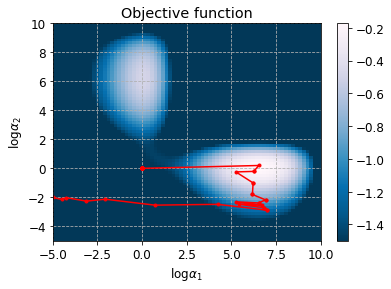

In [27]:
mpl.rcParams.update({'font.size':12})
minVal = -1.5
plt.figure(1)
plt.pcolor(LogAlp1grd,LogAlp2grd,ObjFungrd,cmap='PuBu_r',vmin=minVal)
plt.plot(LogAlpIter[:,0],LogAlpIter[:,1],'r.')
plt.plot(LogAlpIter[:,0],LogAlpIter[:,1],'r-')
plt.colorbar()
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.title('Objective function')
plt.savefig('plot_iter_nm.eps',bbox_inches='tight')